In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

from numpy import genfromtxt

import os

In [4]:
import pickle
import numpy as np

In [63]:
# Workaround for opening Python2 pickle object
with open('datasets/madmom_models-master/onsets/2013/onsets_cnn.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

print(p.layers[6])

In [25]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def get_label_vector(times, onset_times, fuzzy=False):
    a = np.reshape(onset_times, (-1,1))
    b = np.reshape(times, (1,-1))
    onset_onehot = np.sum(np.abs(a - b) < HOP/(2*sr), 0)
    onset_wide = np.sum(np.abs(a - b) < 3*HOP/(2*sr), 0)
    onset_fuzzy = 0.25*onset_wide + 0.25*onset_onehot
    
    if fuzzy: 
        return onset_fuzzy
    else:
        return onset_onehot

In [4]:
frame_dir = 'datasets/initslurtest_vn/frames/'
label_dir = 'datasets/initslurtest_vn/initslurtest_vn_annotations/'
audio_dir = 'datasets/initslurtest_vn/initslurtest_vn_wav/'
HOP = 440
sr = 44100
N_MARGIN = 7 # How many frames to include before and after focus frame
clips_spects = []
clips_onsets = []
for n in range(1,20):
    if n==17:
        continue
        # TODO: solve the 17 case
    print(n)
    
    frame_name = frame_dir + "slurtest{:02d}".format(n) + ".pickle"
    label_name = label_dir+"{:02d}".format(n)+".txt"
    audio_name  = audio_dir + "slurtest{:02d}".format(n) + ".wav"
    
    # Get audio
    audio = tfio.audio.AudioIOTensor(audio_name)
    length = len(audio)/sr
    
    # Get label vector
    with open(frame_name, 'rb') as handle:
        new_spect = np.array(pickle.load(handle))
        print(new_spect.shape)
    times = np.arange(0, length, HOP/sr)
    print("Audio clip defined from {:.3f} s to {:.3f} s".format(0, length))
    print("With a feature frequency of {:.3f} s this yields {} features".format(HOP/sr, len(times)))
    onset_times = genfromtxt(label_name, delimiter=',')
    print("Onsets start at {} and end at {}".format(onset_times[0], onset_times[-1]))
    labels = get_label_vector(times, onset_times, fuzzy=True)[N_MARGIN:-N_MARGIN-1]
    print(labels.shape)
    print()
    clips_spects.append(new_spect)
    clips_onsets.append(labels)

1
(1686, 80, 15, 3)
Audio clip defined from 0.000 s to 16.962 s
With a feature frequency of 0.010 s this yields 1701 features
Onsets start at 0.767 and end at 15.158
(1686,)

2
(1609, 80, 15, 3)
Audio clip defined from 0.000 s to 16.196 s
With a feature frequency of 0.010 s this yields 1624 features
Onsets start at 0.598 and end at 14.528
(1609,)

3
(1646, 80, 15, 3)
Audio clip defined from 0.000 s to 16.567 s
With a feature frequency of 0.010 s this yields 1661 features
Onsets start at 0.838 and end at 14.697
(1646,)

4
(1585, 80, 15, 3)
Audio clip defined from 0.000 s to 15.961 s
With a feature frequency of 0.010 s this yields 1600 features
Onsets start at 0.458 and end at 14.867
(1585,)

5
(3403, 80, 15, 3)
Audio clip defined from 0.000 s to 34.099 s
With a feature frequency of 0.010 s this yields 3418 features
Onsets start at 0.488 and end at 31.757
(3403,)

6
(4959, 80, 15, 3)
Audio clip defined from 0.000 s to 49.621 s
With a feature frequency of 0.010 s this yields 4974 features

In [5]:
#
n_train = 13
n_val = 4
n_test = 1
n_tot = n_train + n_val + n_test

# Sample test/val/train split indices
from numpy.random import default_rng
rng = default_rng(119)
split_idx = rng.choice(np.arange(n_tot), size=n_tot, replace=False)

X_train = np.concatenate([clips_spects[i] for i in split_idx[:n_train]])
y_train = np.concatenate([clips_onsets[i] for i in split_idx[:n_train]])

X_val = np.concatenate([clips_spects[i] for i in split_idx[n_train:n_train+n_val]])
y_val = np.concatenate([clips_onsets[i] for i in split_idx[n_train:n_train+n_val]])

X_test = np.concatenate([clips_spects[i] for i in split_idx[-n_test:]])
y_test = np.concatenate([clips_onsets[i] for i in split_idx[-n_test:]])


In [6]:
# Normalize
center_frames_train = X_train[:,:,7,:]
mean_train = center_frames_train.mean(0).reshape((1,80,1,3))
std_train = center_frames_train.std(0, ddof=1).reshape((1,80,1,3))

X_train = (X_train - mean_train)/std_train
X_val = (X_val - mean_train)/std_train
X_test = (X_test - mean_train)/std_train

In [ ]:
# Check
# Std of first band, first channel on train data - should be ~1
print(X_train[:,0,:,0].std(ddof=1))

# Mean of center frames on validation data - should be ~0
# First five bands
print(X_val[:,:,7,:].mean(0)[:5,:])

print(np.max(X_test))

In [7]:
train_samples, y_dim, x_dim, n_channels = X_train.shape

sets = ["Train", "Val", "Test"]
y_vecs = [y_train, y_val, y_test]
X_vecs = [X_train, X_val, X_test]
print("Set\tFrames\tMean\tStd\tOnset ratio")
print("--------------------------")
[print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}".format(
    set_name,
    len(X_vec),
    X_vec.mean(),
    X_vec.std(ddof=1),
    np.sum(y_vec)/len(y_vec)
)) for (set_name, X_vec, y_vec) in zip(sets, X_vecs, y_vecs)]

print()
output_bias = np.sum(y_train)/(len(y_train)-np.sum(y_train)) #onset divided by non-onset samples
print("Output bias: ", output_bias)

Set	Frames	Mean	Std	Onset ratio
--------------------------
Train	45312	0.000	1.000	0.035
Val	13051	-0.115	1.003	0.021
Test	3610	-0.358	1.026	0.012

Output bias:  0.03620615727639139


In [28]:
# Schlüter, Böck 2014 architecture with dropout

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 10,
        kernel_size = (7,3),
        strides = 1
    ), # Remember to transpose images in this architecture correctly
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 20,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(128, activation = 'sigmoid'),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid', 
                          #bias_initializer=tf.keras.initializers.Constant(output_bias)
    )
])

In [8]:
# Same architecture, smaller dimensions, with dropout

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Permute((2,1,3)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (7,3),
        strides = 1
    ),
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    #tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid', 
                          #bias_initializer=tf.keras.initializers.Constant(output_bias)
     )
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    tf.keras.layers.Dense(1, activation = 'sigmoid', 
                          #bias_initializer=tf.keras.initializers.Constant(output_bias)
     )
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 15, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 26, 10)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1120)             

In [31]:
thres = 0.5
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    tf.keras.metrics.FalsePositives(name='fp01', thresholds=0.1),
    tf.keras.metrics.TrueNegatives(name='fn01', thresholds=0.1),
    tf.keras.metrics.FalsePositives(name='fp05', thresholds=0.5),
    tf.keras.metrics.TrueNegatives(name='fn05', thresholds=0.5),
]
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    class_weight = {0: 1., 1: 1/0.035},
    epochs = 10,
    batch_size = 256
)

Epoch 1/10
177/177 [==============================] - 59s 293ms/step - loss: 0.1448 - fp01: 994.0000 - fn01: 39568.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0744 - val_fp01: 244.0000 - val_fn01: 11994.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 2/10
177/177 [==============================] - 35s 198ms/step - loss: 0.1116 - fp01: 1709.0000 - fn01: 38853.0000 - fp05: 5.0000 - fn05: 40557.0000 - val_loss: 0.0674 - val_fp01: 330.0000 - val_fn01: 11908.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 3/10
177/177 [==============================] - 46s 260ms/step - loss: 0.1031 - fp01: 1781.0000 - fn01: 38781.0000 - fp05: 6.0000 - fn05: 40556.0000 - val_loss: 0.0638 - val_fp01: 269.0000 - val_fn01: 11969.0000 - val_fp05: 1.0000 - val_fn05: 12237.0000
Epoch 4/10
177/177 [==============================] - 41s 230ms/step - loss: 0.0994 - fp01: 1801.0000 - fn01: 38761.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0624 - val_fp01: 377.0000 - val_fn01: 11861.

KeyboardInterrupt: 

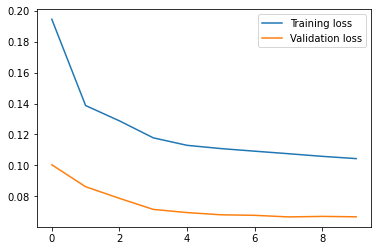

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

ZeroDivisionError: float division by zero

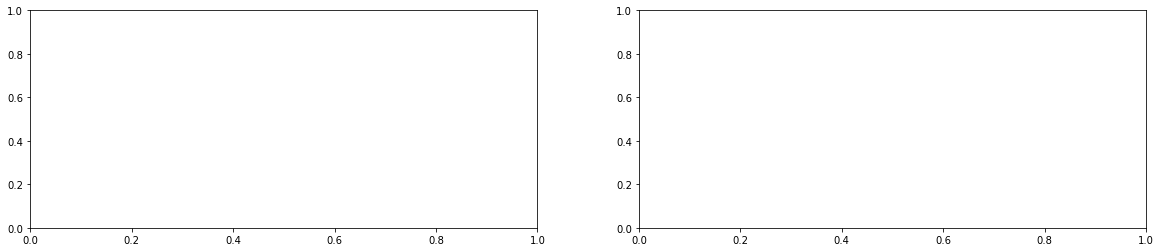

In [13]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['tp'], history.history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['tp'], history.history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['tp'], history.history['fp'], history.history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['val_tp'], history.history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['val_tp'], history.history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['val_tp'], history.history['val_fp'], history.history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

In [ ]:
training_name = "3787-nofuzz-100eps"
with open('results/cnn-training-220316/{}.pickle'.format(training_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
model.evaluate(X_test, y_test)


113/113 [==============================] - 1s 9ms/step - loss: 0.0538 - tp: 0.0000e+00 - fp: 0.0000e+00 - fn: 3475.0000 - f1: 0.0000e+00


[0.053785886615514755, 0.0, 0.0, 3475.0, 0.0]

## Audio analysis and onset extraction

In [15]:
test_index = split_idx[-n_test:][0]
audio = tfio.audio.AudioIOTensor('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index))
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)
print("Test recording: ", test_index)

Test recording:  10


In [16]:
with open('datasets/initslurtest_vn/spectrogram/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    spects=pickle.load(handle)


In [17]:
onset_times = genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index), delimiter=',')
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)
print("Number of true onsets: ", len(onset_times))

Number of true onsets:  52


In [18]:
with open('datasets/initslurtest_vn/frames/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(4020, 80, 15, 3)


Onsets detected:  52


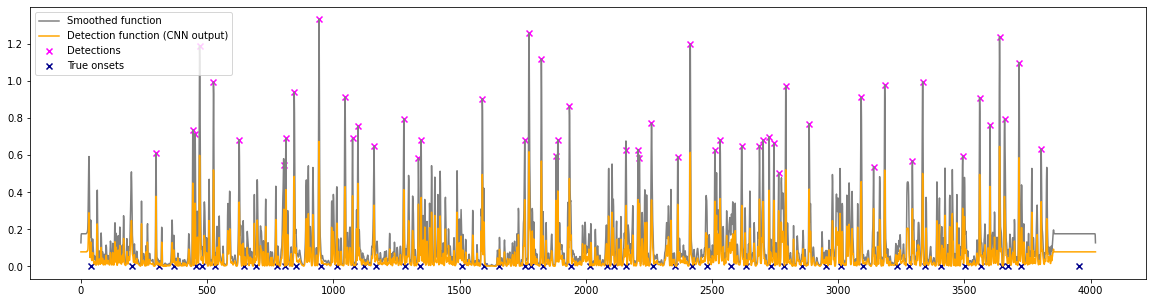

In [21]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

kernel_size = 5
threshold = 0.3

pred_onsets = model.predict(frames)[:,0]
plt.figure(figsize=(20,5))

smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.plot(smoothed, c='gray')
plt.plot(pred_onsets, c='orange')

peaks, _ = find_peaks(pred_onsets, height=threshold)
print("Onsets detected: ", len(peaks))
plt.scatter(peaks, smoothed[peaks], c='magenta', marker='x')

plt.scatter(onset_times*sr/HOP, np.zeros_like(onset_times), marker='x', c='darkblue')
plt.legend(["Smoothed function", "Detection function (CNN output)", "Detections", "True onsets"])
plt.show()

In [22]:
from analyze_detection import evaluate

true = onset_times
pred = peaks*HOP/sr

[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=0.25)

print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))

Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()